# Redes Generativas Antagonicas - GAN

### Requisitos: pip install tensorflow numpy matplotlib

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2025-05-07 22:20:29.377688: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 22:20:29.388124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746678029.397068   52277 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746678029.399604   52277 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746678029.406926   52277 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# cargar el dataset MNIST
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0  # normalizar imágenes entre 0 y 1
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')  # cambiar la forma a (num_samples, 28, 28, 1)

In [3]:
# tamaño del espacio latente (ruido de entrada para el generador)
latent_dim = 100

In [4]:
# crear el generador
def build_generator():
    model = Sequential(
        [
            Dense(256, input_dim=latent_dim),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(512),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(1024),
            LeakyReLU(alpha=0.2),
            BatchNormalization(),
            Dense(28 * 28 * 1, activation="tanh"),
            Reshape((28, 28, 1)),
        ]
    )
    return model

In [5]:
# crear el discriminador
def build_discriminador():
    model = Sequential(
        [
            Flatten(input_shape=(28, 28, 1)),
            Dense(512),
            LeakyReLU(alpha=0.2),
            Dense(1, activation="sigmoid"),  # clasificacion entre real 1 y falso 0
        ]
    )
    return model

In [6]:
# compilar el model
discriminador = build_discriminador()
discriminador.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

/mnt/data/files/url/url-notas/docs/0-RES/IA/jupyter/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/mnt/data/files/url/url-notas/docs/0-RES/IA/jupyter/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1746678037.478270   52277 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6125 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
# compilar el generador (dentro de GAN)
generador = build_generator()

/mnt/data/files/url/url-notas/docs/0-RES/IA/jupyter/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# congelar el discriminador durante el entrenamiento del generador
discriminador.trainable = False

# crear la GAN combinando el generador y el discriminador
gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminador(generador(gan_input))
gan = tf.keras.Model(gan_input, gan_output)

In [9]:
# compilar la GAN
gan.compile(
    optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
    loss="binary_crossentropy",
)

In [10]:
def generate_and_save_images(
    epoch, generator, ejemplos=16, dim=(4, 4), figsize=(10, 10)
):
    noise = np.random.normal(0, 1, size=(ejemplos, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(ejemplos, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        # crear una subgráfica para cada imagen generada
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray_r")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"gan_generated_epoch_{epoch}.png")
    plt.show()


In [11]:
def train_gan(epochs=10000, batch_size=128):
    batch_count = x_train.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            generated_images = generador.predict(noise)
            real_images = x_train[
                np.random.randint(0, x_train.shape[0], size=batch_size)
            ]

            X = np.concatenate([real_images, generated_images])
            Y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])

            d_loss = discriminador.train_on_batch(X, Y)
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            d_loss_val = d_loss[0] if isinstance(d_loss, (list, tuple)) else d_loss
            g_loss_val = g_loss[0] if isinstance(g_loss, (list, tuple)) else g_loss

            print(
                f"Epoch {epoch} | Discriminator Loss: {d_loss_val} | Generator Loss: {g_loss_val}"
            )

            generate_and_save_images(epoch, generador)


I0000 00:00:1746678038.139422   52391 service.cc:152] XLA service 0x72f750004190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746678038.139436   52391 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-07 22:20:38.149662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746678038.182886   52391 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746678038.273964   52391 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


/mnt/data/files/url/url-notas/docs/0-RES/IA/jupyter/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
2025-05-07 22:20:39.955625: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_482', 28 bytes spill stores, 28 bytes spill loads

2025-05-07 22:20:40.122005: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_482', 248 bytes spill stores, 248 bytes spill loads

2025-05-07 22:20:40.136629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_482', 292 bytes spill stores, 292 bytes spill loads

2025-05-07 22:20:40.30

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━

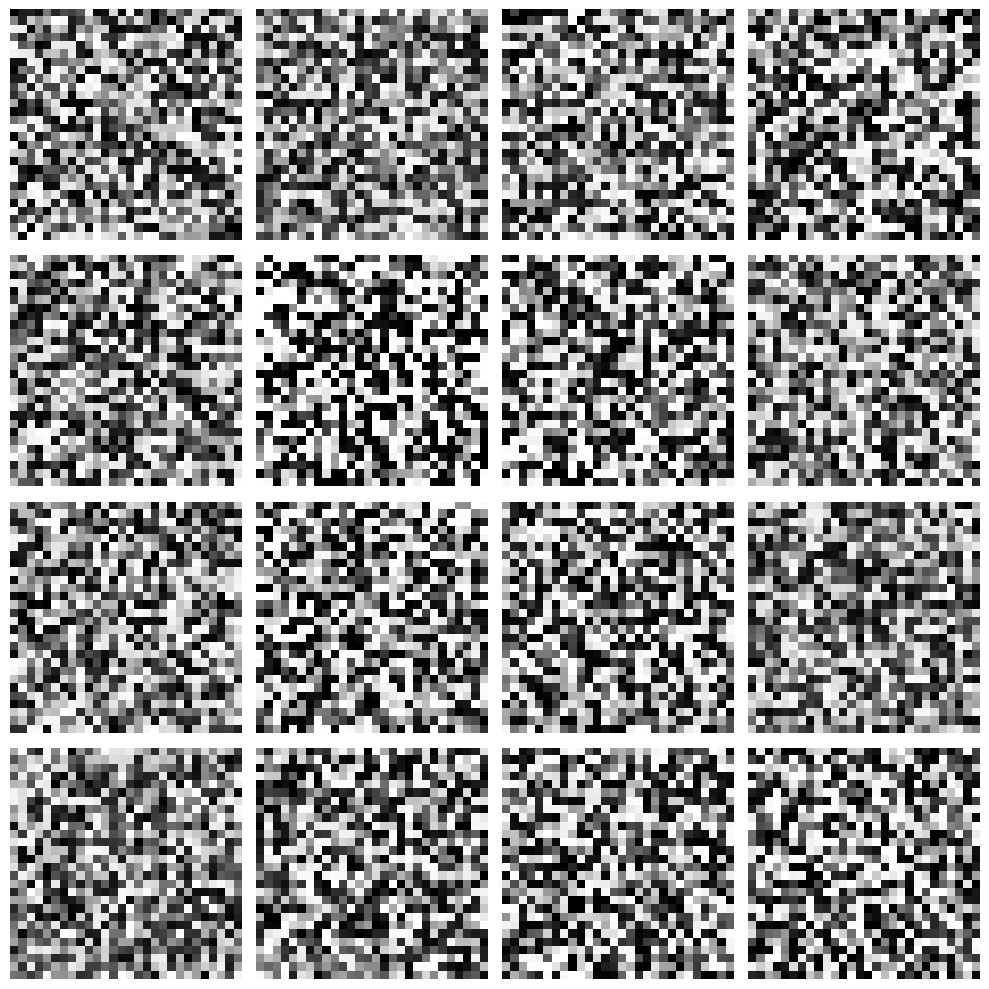

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━

KeyboardInterrupt: 

In [12]:
train_gan(epochs=10000, batch_size=128)